# Injecting modes in bent and angled waveguides

Here, we illustrate how we can use the [ModeSource](../api/_autosummary/tidy3d.ModeSource.html) and [ModeMonitor](../api/_autosummary/tidy3d.ModeMonitor.html) objects to study modes in bent and angled waveguides. This is very useful in simulations such as the [waveguide to ring coupling](https://www.flexcompute.com/tidy3d/examples/notebooks/WaveguideToRingCoupling/).

For more simulation examples, please visit our [examples page](https://www.flexcompute.com/tidy3d/examples/). If you are new to the finite-difference time-domain (FDTD) method, we highly recommend going through our [FDTD101](https://www.flexcompute.com/fdtd101/) tutorials. FDTD simulations can diverge due to various reasons. If you run into any simulation divergence issues, please follow the steps outlined in our [troubleshooting guide](https://www.flexcompute.com/tidy3d/examples/notebooks/DivergedFDTDSimulation/) to resolve it.

In [1]:
# standard python imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# tidy3D import
import tidy3d as td
from tidy3d import web
from tidy3d.plugins.mode import ModeSolver


### Bent waveguide setup

First, we will study mode injection and decomposition in a microring. We start by defining various simulation parameters, and the structures that enter the simulation. We simulate a silicon ring on a silicon oxide substrate, and the ring is defined using two Cylinders.

In [2]:
# Unit length is micron.
wg_height = 0.22
wg_width = 0.9
# Radius of the simulated ring
radius = 2

# Waveguide and substrate materials
mat_wg = td.Medium(permittivity=3.48**2)
mat_sub = td.Medium(permittivity=1.45**2)

# Free-space wavelength (in um) and frequency (in Hz)
lambda0 = 1.55
freq0 = td.C_0 / lambda0
fwidth = freq0 / 10

# Simulation size inside the PML along propagation direction
sim_length = radius + 1.5

# Simulation domain size, resolution and total run time
sim_size = [sim_length, 2 * (radius + 1.5), 3]
run_time = 20 / fwidth
grid_spec = td.GridSpec.auto(min_steps_per_wvl=20, wavelength=lambda0)

# Substrate
substrate = td.Structure(
    geometry=td.Box(
        center=[0, 0, -sim_size[2]],
        size=[td.inf, td.inf, 2 * sim_size[2] - wg_height],
    ),
    medium=mat_sub,
)

# The ring is made by two cylinders
cyl1 = td.Structure(
    geometry=td.Cylinder(
        center=[0, 0, 0],
        radius=radius - wg_width / 2,
        length=wg_height,
        axis=2,
    ),
    medium=td.Medium(),
)
cyl2 = td.Structure(
    geometry=td.Cylinder(
        center=[0, 0, 0],
        radius=radius + wg_width / 2,
        length=wg_height,
        axis=2,
    ),
    medium=mat_wg,
)


### Modal planes in bent waveguides

As usual, when initializing `ModeSource` and `ModeMonitor` objects, one of the three values of the `size` parameter must be zero. In this example, we also need to define the axis of the bend and the radius of the curvature. The definitions are schematically illustrated in the image below. The bend axis is the axis normal to the plane in which the bend lies, (`'z'` in the diagram below). In the mode specification, it is defined *locally* for the mode plane as one of the two axes tangential to the plane. In the case of bends that lie in the `xy`-plane, the mode plane would be either in `xz` or in `yz`, so in both cases the correct setting is `bend_axis=1`, selecting the global `z`. The bend radius is counted from the center of the mode plane to the center of the curvature, along the tangential axis perpendicular to the bend axis. This radius can also be negative, if the center of the mode plane is smaller than the center of the bend, which is what we will encounter in this example. Finally, we note that the `'forward'` and `'backward'` direction parameter can still be used to distinguish between the two propagation directions as in regular modal sources and monitors.

<img src="img/ring_modes.png" width=800>

In [3]:
# xy-plane frequency-domain field monitor; slightly offset in z for better structure viz below
field_mnt = td.FieldMonitor(
    center=[0, 0, 0.05], size=[td.inf, td.inf, 0], freqs=[freq0], name="field"
)

# Flux monitor along the ring propagation direction
flux_mnt = td.FluxMonitor(
    center=[0, radius, 0], size=[0, 3, 2], freqs=[freq0], name="flux"
)


### Running the simulation 

First, we visualize the simulation to make sure we have set up the device correctly. We will use `'absorber'` boundaries along the x-direction, because these boundaries work better than PML for structures which are not translationally invariant along the boundary normal direction. 

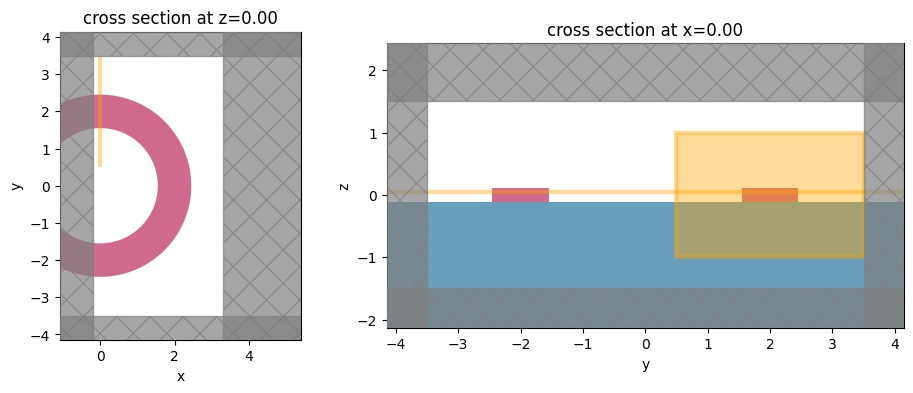

In [4]:
# Simulation
sim = td.Simulation(
    center=[sim_length / 2 - 0.2, 0, 0],
    size=sim_size,
    grid_spec=grid_spec,
    structures=[substrate, cyl2, cyl1],
    sources=[],
    monitors=[field_mnt, flux_mnt],
    run_time=run_time,
    boundary_spec=td.BoundarySpec(
        x=td.Boundary.absorber(), y=td.Boundary.pml(), z=td.Boundary.pml()
    ),
)

fig = plt.figure(figsize=(11, 4))
gs = mpl.gridspec.GridSpec(1, 2, figure=fig, width_ratios=[1, 2])
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
sim.plot(z=0, ax=ax1)
sim.plot(x=0, ax=ax2)
plt.show()


Note that Tidy3D is warning us that the simulation does not contain a source. However, since this simulation is used to construct the mode solver and will not be run directly, we can ignore this warning.

Next, we can compute the source modes to make sure that we inject the desired mode. When a bend radius $R$ is used, the effective index $n$ returned by the solver is such that the field evolves as $e^{i n k_0 R \phi}$, with $\phi$ the polar angle and $k_0 = \omega/c$. This definition is such that in the limit of infinite $R$, the effective index approaches that of a straight waveguide with the same cross-section. Based on our discussion and diagram above, we set the `bend_axis` to `1`, and the `bend_radius` at the position of the source is negative.

22:29:19 PST WARNING: Use the remote mode solver with subpixel averaging for    
             better accuracy through 'tidy3d.plugins.mode.web.run(...)'.        

             WARNING: Mode field at frequency index 0, mode index 2 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 0, mode index 3 does not    
             decay at the plane boundaries.                                     

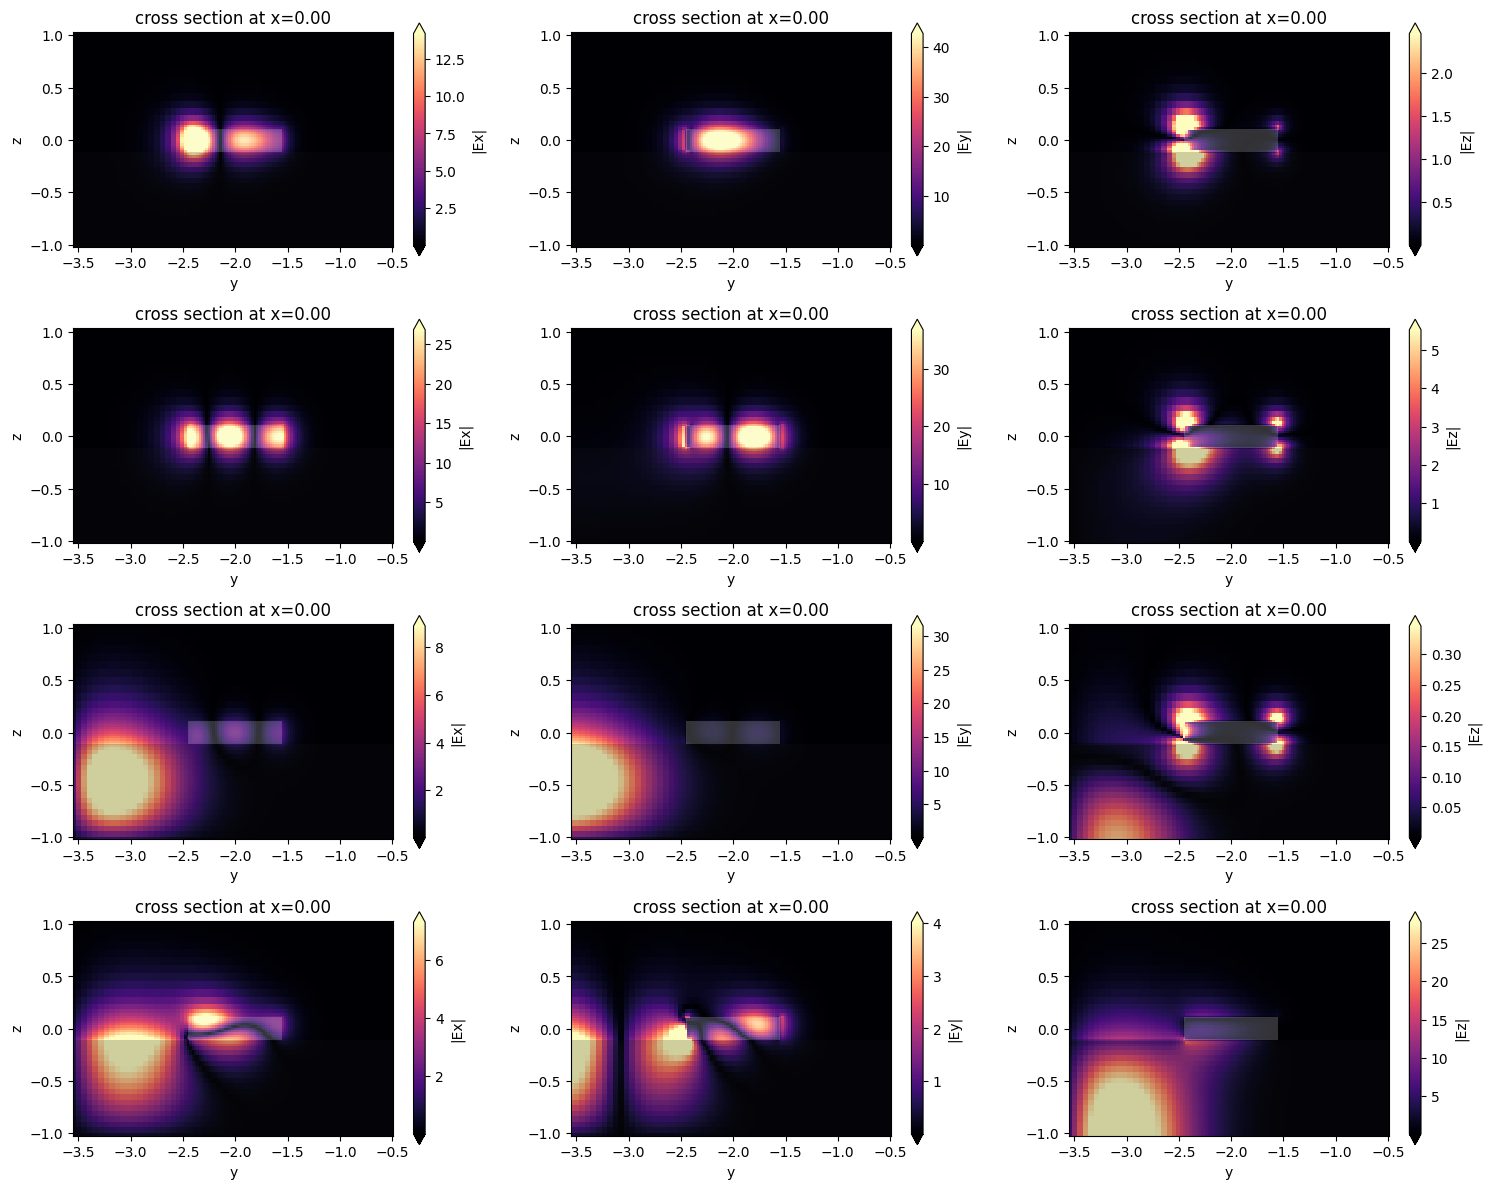

In [5]:
# Modal source plane
source_plane = td.Box(center=[0, -radius, 0], size=[0, 3, 2])

num_modes = 4
# NB: negative radius since the plane position is at y=-radius
mode_spec = td.ModeSpec(num_modes=num_modes, bend_radius=-radius, bend_axis=1)
ms = ModeSolver(simulation=sim, plane=source_plane, freqs=[freq0], mode_spec=mode_spec)

modes = ms.solve()
f, axes = plt.subplots(num_modes, 3, tight_layout=True, figsize=(15, 12))
for axe, mode_index in zip(axes, range(num_modes)):
    for ax, field_name in zip(axe, ("Ex", "Ey", "Ez")):
        ms.plot_field(field_name, "abs", f=freq0, mode_index=mode_index, ax=ax)
plt.show()


Note that the last two of the computed modes are unphysical and for such modes that do not decay to zero at the plane boundary Tidy3D issues warnings. The fundamental mode looks like what we would expect, and we will use that mode for injection. Below, we also define a mode monitor, which is situated radially from the mode source, and so we use a positive value for the bend radius.

In [6]:
# Mode source directly exported from the mode solver above
source_time = td.GaussianPulse(freq0=freq0, fwidth=fwidth)
mode_src = ms.to_source(source_time=source_time, mode_index=0, direction="+")

# Mode monitor after one-half round-trip around the ring; NB: positive radius
mode_mnt = td.ModeMonitor(
    center=[0, radius, 0],
    size=[0, 3, 2],
    freqs=[freq0],
    mode_spec=td.ModeSpec(num_modes=2, bend_radius=radius, bend_axis=1),
    name="modes",
)

sim = sim.copy(update=dict(sources=[mode_src]))
sim = sim.copy(update=dict(monitors=[field_mnt, flux_mnt, mode_mnt]))


In [7]:
sim_data = web.run(sim, task_name="ring_mode", path="data/sim_data.hdf5", verbose=True)


22:29:23 PST Created task 'ring_mode' with task_id                              
             'fdve-6b8586a8-db3e-4520-860f-bdf2c88d9561' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=446779;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6b8586a8-db3e-4520-860f-bdf2c88d9561\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=473543;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6b8586a8-db3e-4520-860f-bdf2c88d9561\taskId]8;;\]8;id=446779;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6b8586a8-db3e-4520-860f-bdf2c88d9561\=]8;;\]8;id=716218;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6b8586a8-db3e-4520-860f-bdf2c88d9561\fdve]8;;\]8;id=446779;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6b8586a8-db3e-4520-860f-bdf2c88d9561\-6b8586a8-db3]8;;\
             ]8;id=446779;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6b8586a8-db3e-4520-860f-bdf2c88d9561\e-4520-860f-bdf2c88d9561']8;;\.

Output()

22:29:25 PST status = queued

Output()

22:29:30 PST status = preprocess

22:29:32 PST Maximum FlexCredit cost: 0.048. Use 'web.real_cost(task_id)' to get
             the billed FlexCredit cost after a simulation run.

             starting up solver

             running solver

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

22:29:46 PST early shutoff detected at 28%, exiting.

             status = postprocess

Output()

22:29:49 PST status = success

22:29:50 PST View simulation result at                                          
             ]8;id=481985;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6b8586a8-db3e-4520-860f-bdf2c88d9561\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=140435;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6b8586a8-db3e-4520-860f-bdf2c88d9561\taskId]8;;\]8;id=481985;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6b8586a8-db3e-4520-860f-bdf2c88d9561\=]8;;\]8;id=135585;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6b8586a8-db3e-4520-860f-bdf2c88d9561\fdve]8;;\]8;id=481985;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6b8586a8-db3e-4520-860f-bdf2c88d9561\-6b8586a8-db3]8;;\
             ]8;id=481985;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6b8586a8-db3e-4520-860f-bdf2c88d9561\e-4520-860f-bdf2c88d9561']8;;\.

Output()

             loading simulation from data/sim_data.hdf5

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

Finally, we visualize the results and verify that we get very close to unity transmission through the half-circle, and all the power is in the fundamental ring mode.

Transmission flux:        [0.9981175]


22:29:51 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

Flux in first two modes:  [0.99709506 0.00279817]


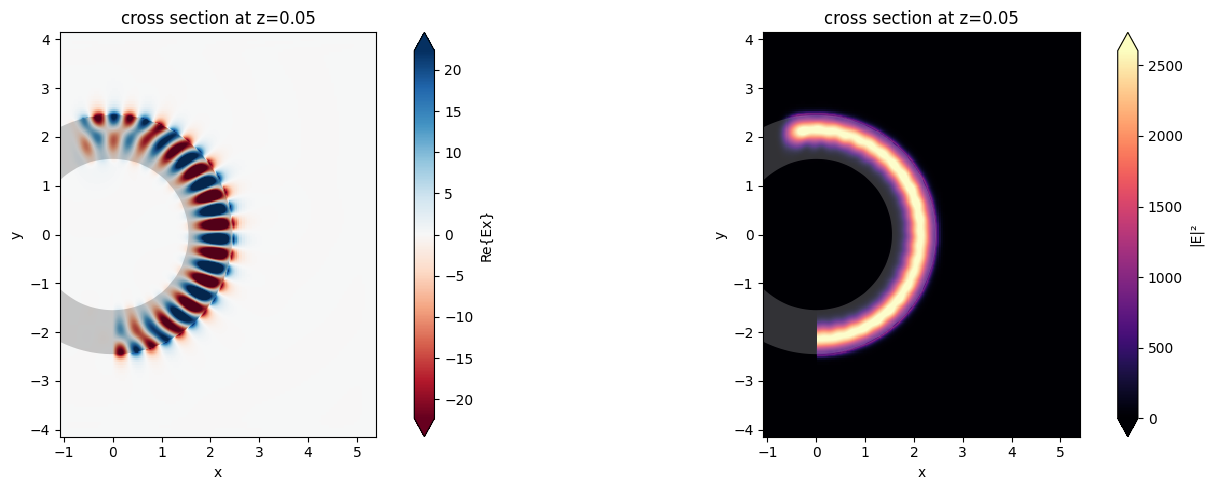

In [8]:
print("Transmission flux:       ", abs(sim_data["flux"].flux.data))
# note: 'backward' mode amplitude
mode_flux = abs(sim_data["modes"].amps.sel(direction="-")) ** 2
print("Flux in first two modes: ", np.array(mode_flux).ravel())

f, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(15, 5))
ax1 = sim_data.plot_field("field", "Ex", z=0.05, f=freq0, val="real", ax=ax1)
ax2 = sim_data.plot_field("field", "E", "abs^2", z=0.05, f=freq0, ax=ax2)
plt.show()


### Angled waveguide setup

`Mode` objects can also be set to inject and record propagation at a given angle with respect to the axis normal to the mode plane. The `angle_theta` and `angle_phi` parameters of `ModeSource` and `ModeMonitor` objects define the injection axis as illustrated in the figure below, with respect to the axis normal to the mode plane (`x` in the figure). Note that `angle_theta` must be smaller than $\pi/2$. To inject in the backward direction, we can still use the `direction` parameter as also shown in the figure. Similarly, the mode amplitudes computed in mode monitors are defined w.r.t. the `forward` and `backward` directions as illustrated.

<img src="img/mode_angled.png" width=500>

In [9]:
# Simulation size
sim_length = 3
sim_size = [sim_length, 5, 2]

# Define an angled waveguide as a PolySlab
wg_width = 0.45
theta = np.pi / 4
phi = np.pi

verts_x = np.array([-10, 10, 10, -10])
verts_y = verts_x * np.tan(theta)
verts_y[:2] -= wg_width / 2 / np.cos(theta)
verts_y[2:] += wg_width / 2 / np.cos(theta)
verts_y *= np.cos(phi)  # this only works for phi = 0 or pi
verts = np.stack((verts_x, verts_y), axis=1)
waveguide = td.Structure(
    geometry=td.PolySlab(vertices=verts, slab_bounds=(-wg_height / 2, wg_height / 2)),
    medium=mat_wg,
)

# Modal source
src_pos = 0
mode_spec = td.ModeSpec(num_modes=2, angle_theta=theta, angle_phi=phi)
msource = td.ModeSource(
    center=[src_pos, 0, 0],
    size=[0, 3, 2],
    source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth),
    direction="+",
    mode_spec=mode_spec,
    mode_index=0,
)

# Angled modal monitor
mnt_f = td.ModeMonitor(
    center=[
        sim_length / 2 - 0.5,
        (sim_length / 2 - 0.5) * np.tan(theta) * np.cos(phi),
        0,
    ],
    size=[0, 3, 2],
    freqs=[freq0],
    mode_spec=mode_spec,
    name="mnt_fwd",
)


We will once again use `'absorber'` boundaries along x, since the angled waveguide is not translationally invariant in that direction.

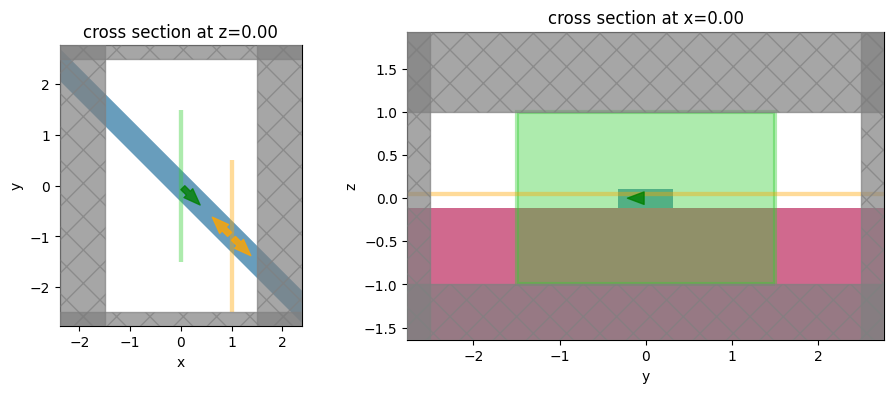

In [10]:
# Simulation
sim = td.Simulation(
    size=sim_size,
    grid_spec=grid_spec,
    structures=[waveguide, substrate],
    sources=[msource],
    monitors=[field_mnt, mnt_f],
    run_time=run_time,
    boundary_spec=td.BoundarySpec(
        x=td.Boundary.absorber(), y=td.Boundary.pml(), z=td.Boundary.pml()
    ),
)

fig = plt.figure(figsize=(11, 4))
gs = mpl.gridspec.GridSpec(1, 2, figure=fig, width_ratios=[1, 2.2])
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
sim.plot(z=0, ax=ax1)
sim.plot(x=0, ax=ax2)
plt.show()


Examine the modes. Note that Tidy3D is warning us about the second mode not decaying to zero at the plane boundary, which could mean that this mode is unphysical.

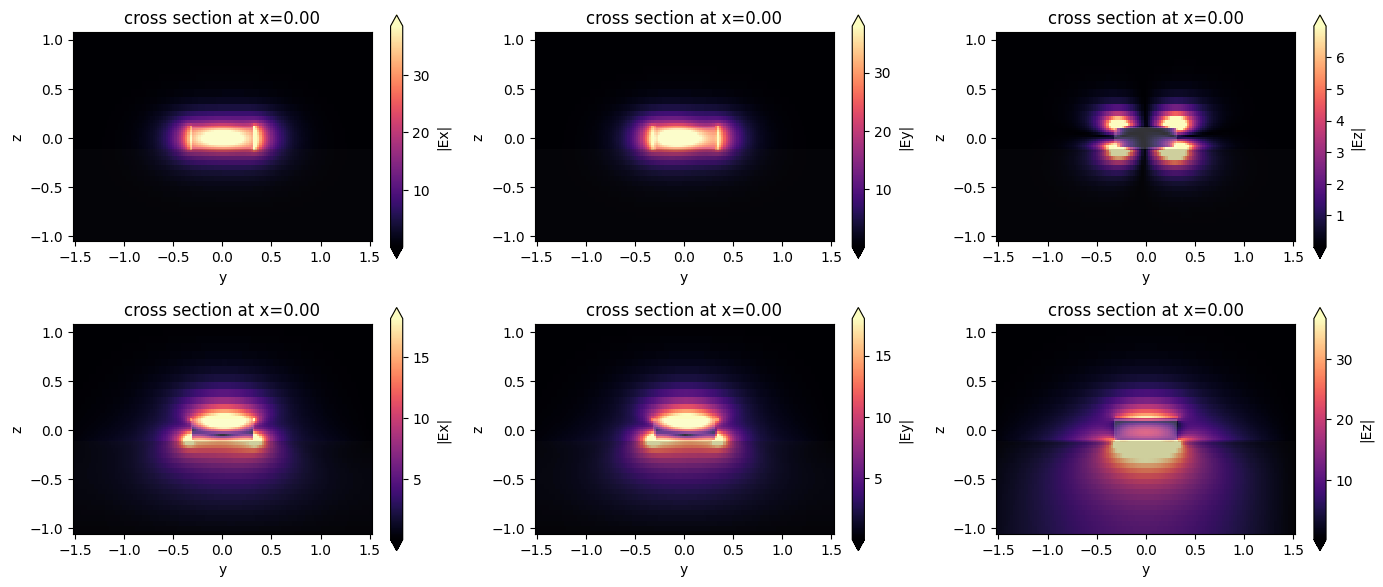

In [11]:
ms = ModeSolver(
    simulation=sim, plane=msource.geometry, mode_spec=mode_spec, freqs=[freq0]
)
modes = ms.solve()

f, axes = plt.subplots(mode_spec.num_modes, 3, tight_layout=True, figsize=(14, 6))
for axe, mode_index in zip(axes, range(mode_spec.num_modes)):
    for ax, field_name in zip(axe, ("Ex", "Ey", "Ez")):
        ms.plot_field(field_name, "abs", f=freq0, mode_index=mode_index, ax=ax)
plt.show()


Run the simulation and plot the results.

In [12]:
sim_data = web.run(
    sim, task_name="angled_waveguide", path="data/sim_data.hdf5", verbose=True
)


22:29:59 PST Created task 'angled_waveguide' with task_id                       
             'fdve-5148a2e7-03e2-4f7e-ac41-ee08baebbf04' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=165083;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5148a2e7-03e2-4f7e-ac41-ee08baebbf04\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=282988;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5148a2e7-03e2-4f7e-ac41-ee08baebbf04\taskId]8;;\]8;id=165083;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5148a2e7-03e2-4f7e-ac41-ee08baebbf04\=]8;;\]8;id=725590;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5148a2e7-03e2-4f7e-ac41-ee08baebbf04\fdve]8;;\]8;id=165083;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5148a2e7-03e2-4f7e-ac41-ee08baebbf04\-5148a2e7-03e]8;;\
             ]8;id=165083;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5148a2e7-03e2-4f7e-ac41-ee08baebbf04\2-4f7e-ac41-ee08baebbf04']8;;\.

Output()

22:30:00 PST status = queued

Output()

22:30:04 PST status = preprocess

22:30:07 PST Maximum FlexCredit cost: 0.042. Use 'web.real_cost(task_id)' to get
             the billed FlexCredit cost after a simulation run.

             starting up solver

             running solver

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

22:30:16 PST early shutoff detected at 20%, exiting.

             status = postprocess

Output()

22:30:19 PST status = success

             View simulation result at                                          
             ]8;id=825649;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5148a2e7-03e2-4f7e-ac41-ee08baebbf04\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=554397;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5148a2e7-03e2-4f7e-ac41-ee08baebbf04\taskId]8;;\]8;id=825649;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5148a2e7-03e2-4f7e-ac41-ee08baebbf04\=]8;;\]8;id=339668;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5148a2e7-03e2-4f7e-ac41-ee08baebbf04\fdve]8;;\]8;id=825649;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5148a2e7-03e2-4f7e-ac41-ee08baebbf04\-5148a2e7-03e]8;;\
             ]8;id=825649;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5148a2e7-03e2-4f7e-ac41-ee08baebbf04\2-4f7e-ac41-ee08baebbf04']8;;\.

Output()

22:30:20 PST loading simulation from data/sim_data.hdf5

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

Flux in first two modes:  [9.99327534e-01 6.24086455e-05]


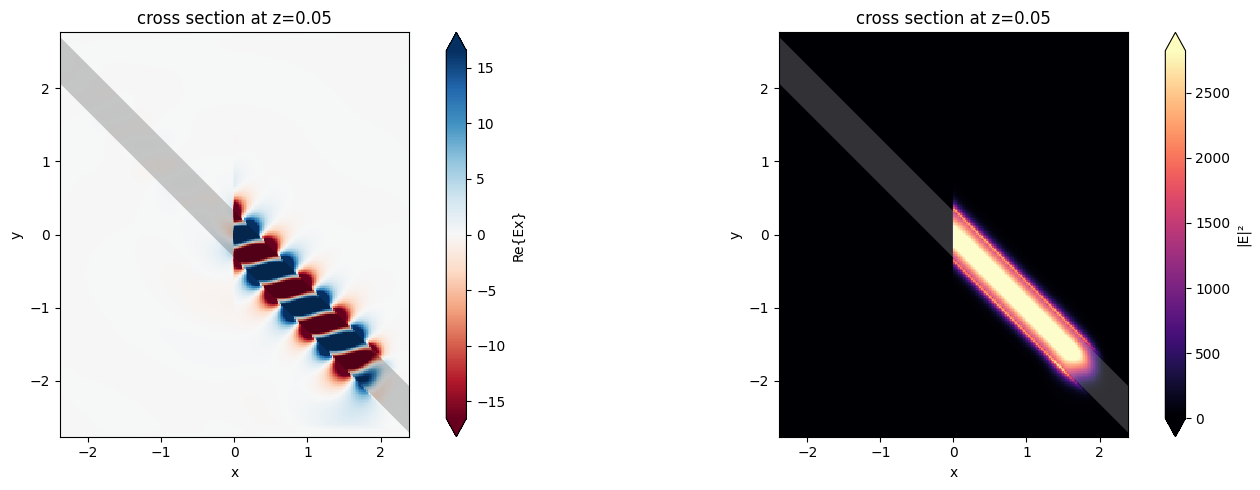

In [13]:
mode_flux = abs(sim_data["mnt_fwd"].amps.sel(direction="+")) ** 2
print("Flux in first two modes: ", np.array(mode_flux).ravel())

f, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(15, 5))
ax1 = sim_data.plot_field("field", "Ex", z=0.05, f=freq0, val="real", ax=ax1)
ax2 = sim_data.plot_field("field", "E", "abs^2", z=0.05, f=freq0, ax=ax2)
plt.show()


### Modes with both a bend and an angle

We can also compose the two functionalities to inject and record modes in a bent waveguide in which the bend curvature is not in the same plane as the mode plane. This is illustrated below, using the same ring simulation but with a modification of the position of the `ModeSource` and `ModeMonitor`.

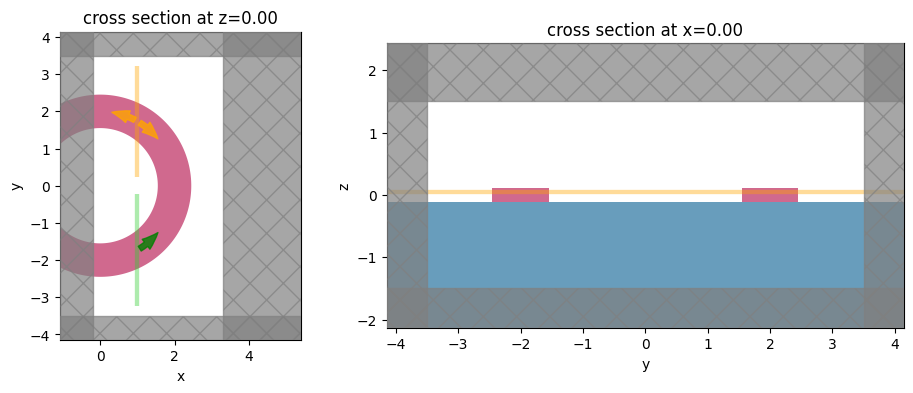

In [14]:
# offset the source and monitor position by 'angle' along the ring
angle = np.pi / 6

# Simulation size for the ring simulation
sim_length = radius + 1.5
sim_size = [sim_length, 2 * (radius + 1.5), 3]

# Note: angle_phi = 0, bend_radius = -r
src_angled = td.ModeSource(
    center=[radius * np.sin(angle), -radius * np.cos(angle), 0],
    size=[0, 3, 2],
    source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth),
    direction="+",
    mode_spec=td.ModeSpec(
        angle_theta=angle,
        angle_phi=0,
        bend_radius=-radius,
        bend_axis=1,
    ),
)

# Note: angle_phi = np.pi, bend_radius = r
mnt_angled = td.ModeMonitor(
    center=[radius * np.sin(angle), radius * np.cos(angle), 0],
    size=[0, 3, 2],
    freqs=[freq0],
    mode_spec=td.ModeSpec(
        num_modes=2,
        angle_theta=angle,
        angle_phi=np.pi,
        bend_radius=radius,
        bend_axis=1,
    ),
    name="modes",
)

# Simulation
sim = td.Simulation(
    center=[sim_length / 2 - 0.2, 0, 0],
    size=sim_size,
    grid_spec=grid_spec,
    structures=[substrate, cyl2, cyl1],
    sources=[src_angled],
    monitors=[field_mnt, mnt_angled],
    run_time=run_time,
    boundary_spec=td.BoundarySpec(
        x=td.Boundary.absorber(), y=td.Boundary.pml(), z=td.Boundary.pml()
    ),
    subpixel=True,
)

fig = plt.figure(figsize=(11, 4))
gs = mpl.gridspec.GridSpec(1, 2, figure=fig, width_ratios=[1, 2])
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
sim.plot(z=0, ax=ax1)
sim.plot(x=0, ax=ax2)
plt.show()


In [15]:
sim_data = web.run(
    sim, task_name="angled_ring", path="data/sim_data.hdf5", verbose=True
)


22:30:22 PST Created task 'angled_ring' with task_id                            
             'fdve-b512762e-ec21-46b1-9d6e-3a3531da3e0b' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=501789;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b512762e-ec21-46b1-9d6e-3a3531da3e0b\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=795302;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b512762e-ec21-46b1-9d6e-3a3531da3e0b\taskId]8;;\]8;id=501789;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b512762e-ec21-46b1-9d6e-3a3531da3e0b\=]8;;\]8;id=173389;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b512762e-ec21-46b1-9d6e-3a3531da3e0b\fdve]8;;\]8;id=501789;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b512762e-ec21-46b1-9d6e-3a3531da3e0b\-b512762e-ec2]8;;\
             ]8;id=501789;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b512762e-ec21-46b1-9d6e-3a3531da3e0b\1-46b1-9d6e-3a3531da3e0b']8;;\.

Output()

22:30:23 PST status = queued

Output()

22:30:28 PST status = preprocess

22:30:31 PST Maximum FlexCredit cost: 0.053. Use 'web.real_cost(task_id)' to get
             the billed FlexCredit cost after a simulation run.

             starting up solver

             running solver

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

22:30:43 PST early shutoff detected at 28%, exiting.

22:30:44 PST status = postprocess

Output()

22:30:46 PST status = success

22:30:47 PST View simulation result at                                          
             ]8;id=490067;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b512762e-ec21-46b1-9d6e-3a3531da3e0b\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=481778;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b512762e-ec21-46b1-9d6e-3a3531da3e0b\taskId]8;;\]8;id=490067;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b512762e-ec21-46b1-9d6e-3a3531da3e0b\=]8;;\]8;id=275924;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b512762e-ec21-46b1-9d6e-3a3531da3e0b\fdve]8;;\]8;id=490067;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b512762e-ec21-46b1-9d6e-3a3531da3e0b\-b512762e-ec2]8;;\
             ]8;id=490067;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b512762e-ec21-46b1-9d6e-3a3531da3e0b\1-46b1-9d6e-3a3531da3e0b']8;;\.

Output()

22:30:48 PST loading simulation from data/sim_data.hdf5

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

Flux in first two modes:  [0.99269777 0.00857492]


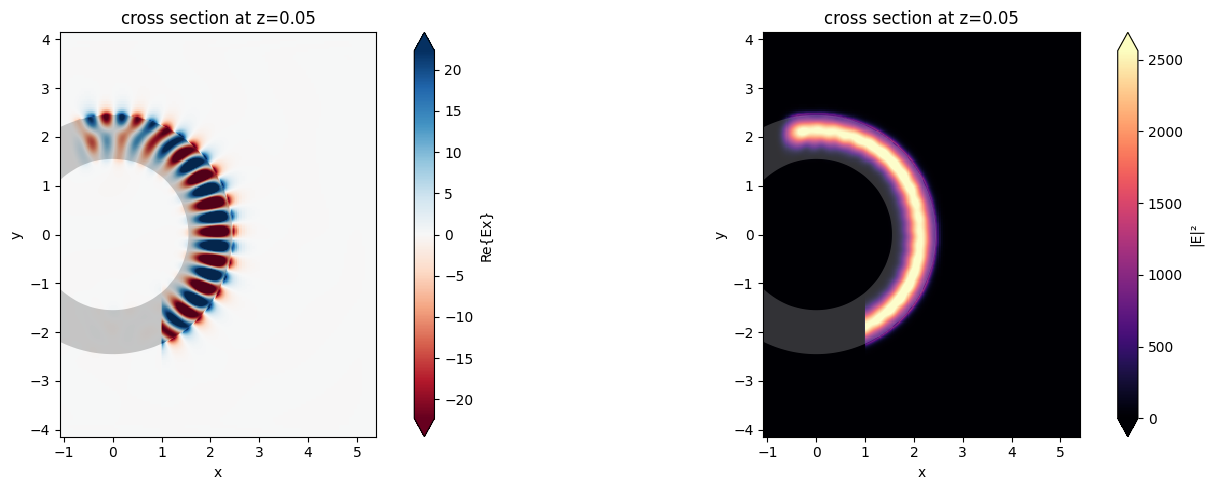

In [16]:
mode_flux = abs(sim_data["modes"].amps.sel(direction="-")) ** 2
print("Flux in first two modes: ", np.array(mode_flux).ravel())

f, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(15, 5))
ax1 = sim_data.plot_field("field", "Ex", z=0.05, f=freq0, val="real", ax=ax1)
ax2 = sim_data.plot_field("field", "E", "abs^2", z=0.05, f=freq0, ax=ax2)
plt.show()


For more integrated photonic examples such as the [8-Channel mode and polarization de-multiplexer](https://www.flexcompute.com/tidy3d/examples/notebooks/8ChannelDemultiplexer/), the [broadband bi-level taper polarization rotator-splitter](https://www.flexcompute.com/tidy3d/examples/notebooks/BilevelPSR/), and the [broadband directional coupler](https://www.flexcompute.com/tidy3d/examples/notebooks/BroadbandDirectionalCoupler/), please visit our [examples page](https://www.flexcompute.com/tidy3d/examples/).

If you are new to the finite-difference time-domain (FDTD) method, we highly recommend going through our [FDTD101](https://www.flexcompute.com/fdtd101/) tutorials. 